In [ ]:
from Data_Enrichment import get_features
RAW_DIR = "data/raw"
df_feats, feature_cols = get_features(RAW_DIR)
df_feats = df_feats[~df_feats['season_end_year'].isin([2026])]

/workspaces/Machine-learning/Data_Enrichment.py:300: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["ballon_dor_winner"] = df["ballon_dor_winner"].fillna(False).astype(bool)


In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# %% Selección de features
features = ['a_per90_z_lag1', 'matches_played_z_lag1', 'ga_per90_z_lag1',
       'pen_share_z_lag1', 'g_per90_z_lag1', 'g_per90_z_delta',
       'a_per90_w', 'ga_per90_z_delta', 'ga_per90_w', 'g_per90_w',
       'a_per90_z_delta', 'pen_share_w', 'minutes_played_z_delta',
       'minutes_played_z_lag1', 'pen_share_z_delta',
       'main_position', 'age', 'height', 'discipline_rate_z_lag1',
       'position']

df = df_feats[features].copy()
df = pd.get_dummies(df, columns=['main_position','position'], drop_first=True)


In [4]:
# %% Tomar una muestra aleatoria para no explotar memoria
sample_frac = 0.2  # 20% de los datos
df_sample = df.sample(frac=sample_frac, random_state=42)

In [5]:
# %% Escalado
X_sample = StandardScaler().fit_transform(df_sample)


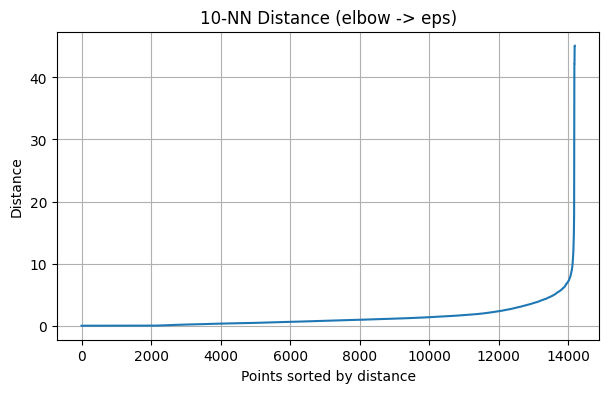

In [6]:
# %% Elegir eps dinámicamente con k-distance
min_samples = 10
nbrs = NearestNeighbors(n_neighbors=min_samples).fit(X_sample)
distances, _ = nbrs.kneighbors(X_sample)
distances = np.sort(distances[:, -1])

plt.figure(figsize=(7,4))
plt.plot(distances)
plt.title(f'{min_samples}-NN Distance (elbow -> eps)')
plt.xlabel('Points sorted by distance')
plt.ylabel('Distance')
plt.grid(True)
plt.show()


In [7]:
# %% DBSCAN
eps_value = distances[int(len(distances)*0.2)]  # percentil 20 para no explotar
dbscan = DBSCAN(eps=eps_value, min_samples=min_samples)
labels = dbscan.fit_predict(X_sample)


In [8]:
# %% Resumen clusters
n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
n_noise = sum(labels == -1)
print(f"Clusters: {n_clusters}, Noise points: {n_noise}")


Clusters: 19, Noise points: 11122


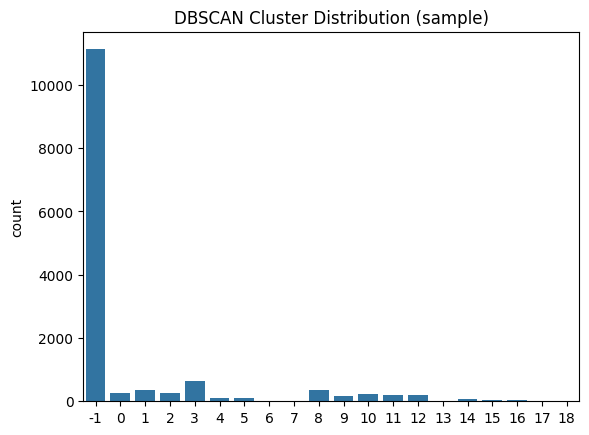

In [9]:
# %% Distribución de clusters
sns.countplot(x=labels)
plt.title('DBSCAN Cluster Distribution (sample)')
plt.show()
